# Decentralized Open-Source Transportation Data Using Blockchain

**Author**: Lemesh Kumar NIshad  
**GitHub**: [Your GitHub Link]  
**Date**: [Date]

---

## Introduction
This project aims to analyze transportation delays and implement a **predictive model** for classifying delay durations. Additionally, we explore the use of blockchain technology to create a decentralized system for logging and storing transportation data (e.g., traffic flow, delays). A simple API is built using Flask to interact with the blockchain, enabling users to add new transportation records and retrieve the blockchain ledger.

---

## Problem Statement
Transportation delays are a significant issue in urban areas, causing inconvenience to passengers and inefficiencies in public transit systems. This project addresses two key challenges:
1. **Predicting Delay Durations**: Develop a machine learning model to classify transportation delays based on historical data.
2. **Decentralized Data Storage**: Implement a blockchain-based system to store transportation data securely and transparently.

---


## Data Exploration
In this section, we explore the dataset to understand its structure, identify patterns, and detect any issues such as missing values or outliers.

### Loading the Dataset
```python
import pandas as pd


In [ ]:
import pandas as pd
#Lode the dataset
df = pd.read_csv("../data/ttc_bus_delay_data_2024.csv")
#Display first 5 rows
df.head()

### Understanding the Dataset

Before diving into analysis, it's important to get a basic understanding of the dataset. Here's what we do:
1. **`df.shape`**: Shows the size of the dataset (rows and columns).  
2. **`df.info()`**: Summarizes column names, data types, and missing values.  
3. **`df.describe()`**: Provides stats like mean, min, max, and quartiles for numerical columns.

In [3]:
# Basic information about the dataset
print(f"Dataset Shape: {df.shape}")
print("\n")
df.info()
print("\n")
df.describe()

Dataset Shape: (54609, 10)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54609 entries, 0 to 54608
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Date       54609 non-null  object
 1   Route      54059 non-null  object
 2   Time       54609 non-null  object
 3   Day        54609 non-null  object
 4   Location   54609 non-null  object
 5   Incident   54609 non-null  object
 6   Min Delay  54609 non-null  int64 
 7   Min Gap    54609 non-null  int64 
 8   Direction  46007 non-null  object
 9   Vehicle    54609 non-null  int64 
dtypes: int64(3), object(7)
memory usage: 4.2+ MB




,Min Delay,Min Gap,Vehicle
count,54609.000000,54609.000000,54609.000000
mean,21.451226,33.836584,5878.846161
std,55.133240,57.299628,3670.851081
min,0.000000,0.000000,0.000000
25%,8.000000,16.000000,3301.000000
50%,11.000000,22.000000,7228.000000
75%,20.000000,40.000000,8581.000000
max,975.000000,997.000000,98035.000000


In [4]:
# Counts the number of missing (empty) values in each column
print(df.isnull().sum())
print("\n")
# Calculate and display the percentage of missing values in each column
missing_percentage = df.isnull().sum() / len(df) * 100  
print(missing_percentage)

Date            0
Route         550
Time            0
Day             0
Location        0
Incident        0
Min Delay       0
Min Gap         0
Direction    8602
Vehicle         0
dtype: int64


Date          0.000000
Route         1.007160
Time          0.000000
Day           0.000000
Location      0.000000
Incident      0.000000
Min Delay     0.000000
Min Gap       0.000000
Direction    15.751982
Vehicle       0.000000
dtype: float64


### Check Data Types & Convert Date Format

In [5]:
# Convert 'Date' column to datetime with a specified format
df['Date'] = pd.to_datetime(df['Date'], format='%d-%b-%y') 

# Convert 'Time' column to proper time format
df['Time'] = pd.to_datetime(df['Time'], format="%H:%M").dt.time

# Display updated data types
df.dtypes

Date         datetime64[ns]
Route                object
Time                 object
Day                  object
Location             object
Incident             object
Min Delay             int64
Min Gap               int64
Direction            object
Vehicle               int64
dtype: object

## Data Preprocessing

### Handle Missing Values 

After checking for missing values, we found that:

- **'Route'** had **550** missing values.
- **'Direction'** had **8602** missing values.
- All other columns had **0** missing values.

Since missing values in these two columns could still provide useful information, we decided **not to drop rows** but instead fill them with `"Unknown"`. This ensures that we do not lose valuable data unnecessarily.

By replacing NaN values with `"Unknown"`:
- We retain all data for analysis.
- We avoid errors caused by missing values.
- We maintain consistency in our dataset.


In [6]:
df.dropna(subset=['Route', 'Direction'], inplace=True)

# Drop rows with any remaining missing values in other columns, if necessary
df.dropna(inplace=True)

### Remove Duplicates

In [7]:
# Drop duplicate rows if any present in the dataset
df.drop_duplicates(inplace=True)

### Encode Categorical Variables

In our dataset, the **'Min Delay'** column represents delay duration in minutes. However, raw delay values can be difficult to analyze, so we classify them into two categories:  

- **Short Delay (<10 min)** – Minor delays that are usually manageable.  
- **Long Delay (≥10 min)** – Significant delays that may disrupt schedules.  

####  Why 10 Minutes?  
- Many transit systems consider delays under **10 minutes** as minor.  
- Longer delays often indicate operational issues that need attention.  
- It simplifies data interpretation and improves machine learning models.  

This classification makes delay data easier to analyze and can be adjusted based on real-world transit policies.  

In [8]:
from sklearn.preprocessing import LabelEncoder

# Convert delay into a binary classification (Short Delay <10 min, Long Delay ≥10 min)
df['Delay_Class'] = df['Min Delay'].apply(lambda x: "Short" if x < 10 else "Long")

# Encode labels (0 = Short, 1 = Long) for machine learning models
encoder = LabelEncoder()
df['Delay_Class'] = encoder.fit_transform(df['Delay_Class'])

# Display first few rows to verify the changes
print(df[['Min Delay', 'Delay_Class']].head())

   Min Delay  Delay_Class
0         10            0
3          0            1
5          8            1
6         20            0
7         21            0


## Exploratory Data Analysis (EDA)

EDA helps us uncover trends and patterns in delay data. In our project, we use **count plots** and other visualizations to make insights clearer and more actionable.

#### Why Use a Count Plot?
We use a count plot to visualize the frequency of different delay incidents. It helps:
- Identify the most common causes of delays.
- Provide a clear comparison of incidents.
- Quickly highlight major operational issues.



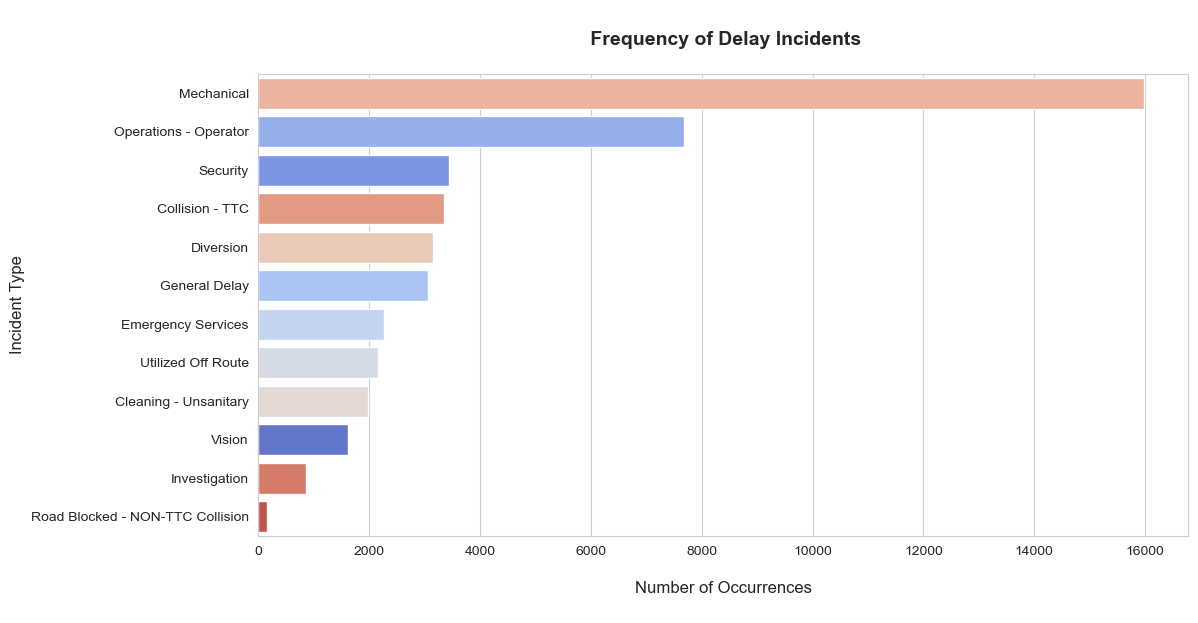

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set style for better visuals
plt.figure(figsize=(12, 6))
sns.set_style("whitegrid")

# Countplot for delay incidents
sns.countplot(
    y=df['Incident'], 
    order=df['Incident'].value_counts().index, 
    palette="coolwarm",
    hue=df['Incident'],
    legend=False
)

# Adding labels and title
plt.title("\n Frequency of Delay Incidents\n", fontsize=14, fontweight="bold")
plt.xlabel("\nNumber of Occurrences\n", fontsize=12)
plt.ylabel("Incident Type", fontsize=12)

# Show the plot
plt.show()

### Making EDA More Presentable

**To gain deeper insights, we also use:**

### Bar Plots & Pie Charts – To compare delay categories.

**Helps us compare how often short vs. long delays occur**


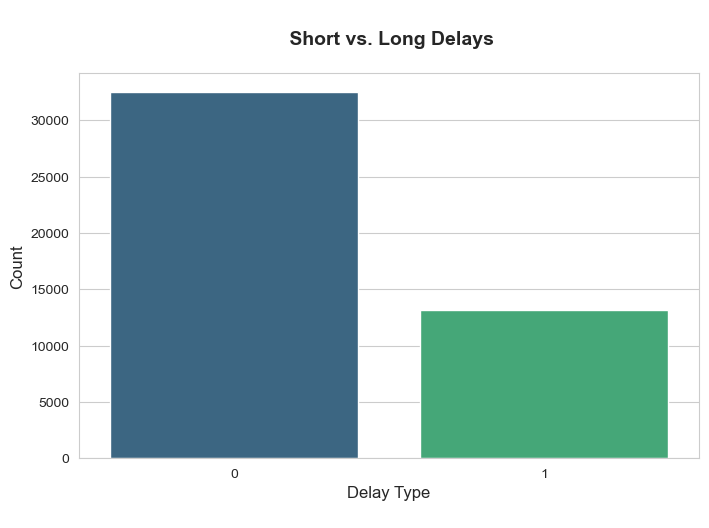

In [10]:
plt.figure(figsize=(8, 5))

# Bar plot for short vs. long delays
sns.barplot(
    x=df['Delay_Class'].value_counts().index, 
    y=df['Delay_Class'].value_counts().values, 
    palette="viridis",
    hue=df['Delay_Class'].value_counts().index,
    legend=False
)

# Adding labels and title
plt.title("\n Short vs. Long Delays\n", fontsize=14, fontweight="bold")
plt.xlabel("Delay Type\n", fontsize=12)
plt.ylabel("Count", fontsize=12)

plt.show()

### Line Charts – To analyze delay trends over time.

**Shows how delays fluctuate over time, helping to detect trends.**


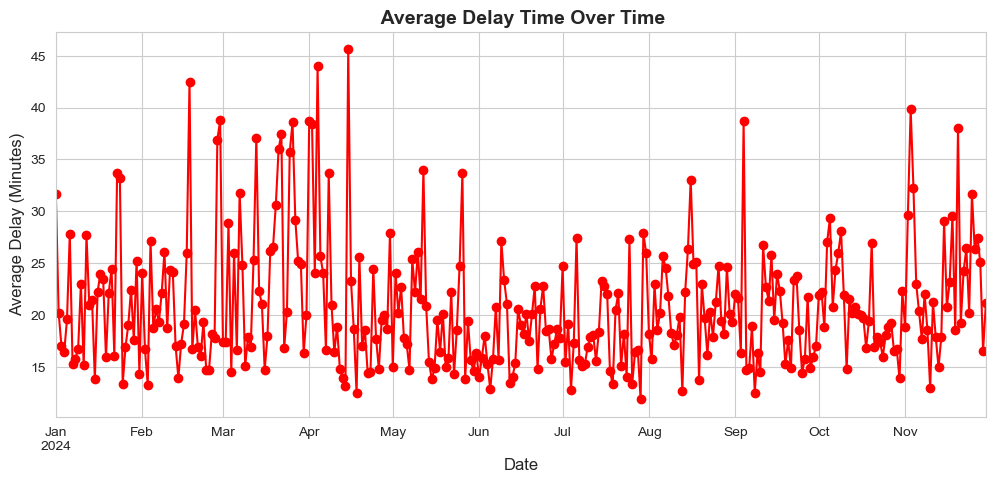

In [11]:
plt.figure(figsize=(12, 5))

# Convert Date column to datetime format if not already done
df['Date'] = pd.to_datetime(df['Date'])

# Line plot for average delay per day
df.groupby('Date')['Min Delay'].mean().plot(marker='o', linestyle='-', color='red')

# Adding labels and title
plt.title(" Average Delay Time Over Time", fontsize=14, fontweight="bold")
plt.xlabel("Date", fontsize=12)
plt.ylabel("Average Delay (Minutes)", fontsize=12)

plt.show()

 ## Model Building

 ### Preparing Data for Machine Learning

#### **Why is this important?**
Before training a model, we must:
1. **Select relevant features**: Choose the columns that will help the model make predictions.
2. **Convert text into numbers**: Machine learning models only understand numbers, so we need to encode categorical text data.
3. **Split the data into training & testing sets**: This ensures we can evaluate the model's performance on unseen data.



In [12]:
from sklearn.model_selection import train_test_split 

# Step 1: Select relevant features
# We choose the columns (features) that are most relevant for predicting the target variable (`Delay_Class`).
features = ['Route', 'Day', 'Incident', 'Direction']  
X = df[features]  # Features (independent variables)
y = df['Delay_Class']  # Target variable (dependent variable)


# Step 2: Convert categorical text into numerical values
# Machine learning models cannot work with text directly, so we use one-hot encoding to convert categorical text features into numerical values.
X = pd.get_dummies(X, drop_first=True)


# Step 3: Split data into training and testing sets
# We split the data into two parts:
# - Training set (80%): Used to train the model.
# - Testing set (20%): Used to evaluate the model's performance on unseen data.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Check the shape of the training and testing sets
print(f"Training set shape: {X_train.shape}")  # Output: (Number of rows, Number of features)
print(f"Testing set shape: {X_test.shape}")    # Output: (Number of rows, Number of features)
# `random_state=42` ensures the split is reproducible (same split every time you run the code).


Training set shape: (36556, 274)
Testing set shape: (9139, 274)


### Training Machine Learning Models

We use **3 models** to predict transportation delays:
1. **Logistic Regression**: Simple and interpretable. Good for baseline performance.
2. **Random Forest**: Handles complex relationships and avoids overfitting.
3. **XGBoost**: State-of-the-art performance with high accuracy for structured data.

Comparing these models helps us:
- Find the best-performing model for our dataset.
- Balance accuracy, speed, and complexity.
- Ensure the model generalizes well to new/unseen data.

Confusion matrices help us to visualize:
- **True Positives (TP)**: Correctly predicted delays.
- **False Positives (FP)**: Incorrectly predicted delays (Type I error).
- **False Negatives (FN)**: Missed delay predictions (Type II error).
- **True Negatives (TN)**: Correctly predicted no delays.

This helps identify **model strengths/weaknesses** for each class (e.g., short vs. long delays).


In [13]:
# Step 1: Import Libraries

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Set plot style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

#### Step 2: Train & Evaluate Models

**Model 1: Logistic regression**

Logistic Regression Performance:

Accuracy: 0.78
Precision: 0.77
Recall: 0.78
F1-Score: 0.77





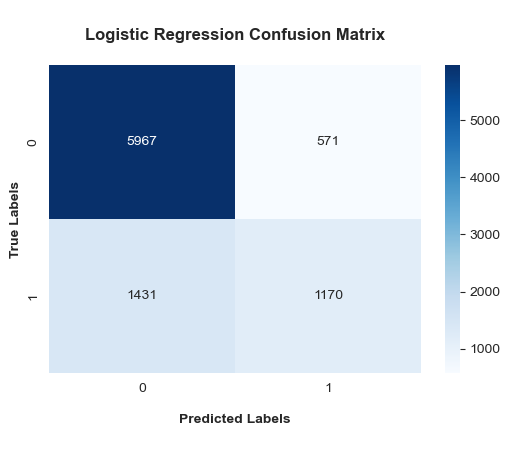

In [14]:
# Initialize the model
logir_model = LogisticRegression(max_iter=1000)  
# Train the model
logir_model.fit(X_train, y_train)
# Predict on test data
logir_predictions = logir_model.predict(X_test)

# Evaluate
print("Logistic Regression Performance:\n")
print(f"Accuracy: {accuracy_score(y_test, logir_predictions):.2f}")
print(f"Precision: {precision_score(y_test, logir_predictions, average='weighted'):.2f}")
print(f"Recall: {recall_score(y_test, logir_predictions, average='weighted'):.2f}")
print(f"F1-Score: {f1_score(y_test, logir_predictions, average='weighted'):.2f}")
print("\n\n")

# Plot confusion matrix
logir_cm = confusion_matrix(y_test, logir_predictions)
plt.figure(figsize=(6, 4))
sns.heatmap(logir_cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=logir_model.classes_, 
            yticklabels=logir_model.classes_)
plt.title("\nLogistic Regression Confusion Matrix\n", fontweight='bold')
plt.xlabel("\nPredicted Labels\n",fontweight='bold')
plt.ylabel("True Labels",fontweight='bold')
plt.show()

#### Model 2: Random Forest


 Random Forest Performance:

Accuracy: 0.77
Precision: 0.77
Recall: 0.77
F1-Score: 0.77




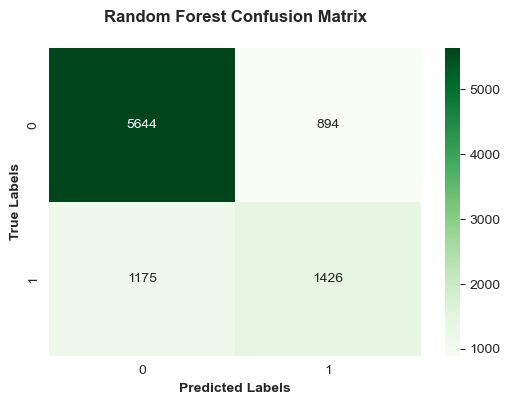

In [15]:
# Initialize and train the model
randomf_model = RandomForestClassifier(n_estimators=100, random_state=42)
randomf_model.fit(X_train, y_train)
randomf_predictions = randomf_model.predict(X_test)

# Evaluate
print("\n Random Forest Performance:\n")
print(f"Accuracy: {accuracy_score(y_test, randomf_predictions):.2f}")
print(f"Precision: {f1_score(y_test, randomf_predictions, average='weighted'):.2f}")
print(f"Recall: {f1_score(y_test, randomf_predictions, average='weighted'):.2f}")
print(f"F1-Score: {f1_score(y_test, randomf_predictions, average='weighted'):.2f}")
print("\n")

# Plot confusion matrix
randomf_cm = confusion_matrix(y_test, randomf_predictions)
plt.figure(figsize=(6, 4))
sns.heatmap(randomf_cm, annot=True, fmt='d', cmap='Greens', 
            xticklabels=randomf_model.classes_, 
            yticklabels=randomf_model.classes_)
plt.title("Random Forest Confusion Matrix\n", fontweight='bold')
plt.xlabel("Predicted Labels",fontweight='bold')
plt.ylabel("True Labels",fontweight='bold')
plt.show()

#### Model 3: XGBoost

 XGBoost Performance:
Accuracy: 0.78
Precision: 0.76
Recall: 0.76
F1-Score: 0.76




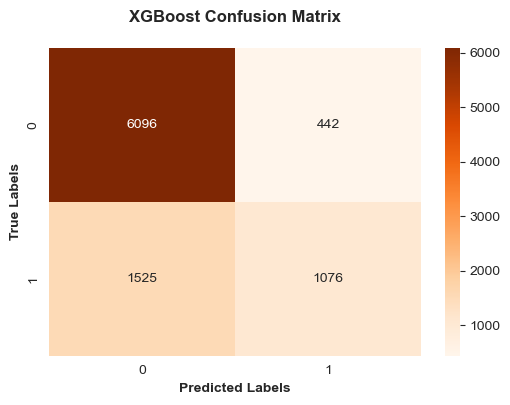

In [16]:
# Initialize and train the model
xgb_model = XGBClassifier(n_estimators=100, learning_rate=0.1, random_state=42)
xgb_model.fit(X_train, y_train)
xgb_predictions = xgb_model.predict(X_test)

# Evaluate
print(" XGBoost Performance:")
print(f"Accuracy: {accuracy_score(y_test, xgb_predictions):.2f}")
print(f"Precision: {f1_score(y_test, xgb_predictions, average='weighted'):.2f}")
print(f"Recall: {f1_score(y_test, xgb_predictions, average='weighted'):.2f}")
print(f"F1-Score: {f1_score(y_test, xgb_predictions, average='weighted'):.2f}")
print("\n")
# Plot confusion matrix
xgb_cm = confusion_matrix(y_test, xgb_predictions)
plt.figure(figsize=(6, 4))
sns.heatmap(xgb_cm, annot=True, fmt='d', cmap='Oranges', 
            xticklabels=xgb_model.classes_, 
            yticklabels=xgb_model.classes_)
plt.title("XGBoost Confusion Matrix\n", fontweight='bold')
plt.xlabel("Predicted Labels",fontweight='bold')
plt.ylabel("True Labels",fontweight='bold')
plt.show()

#### Step 3: Compare Models

In [17]:
# Create a comparison table
results = {
    'Model': ['Logistic Regression', 'Random Forest', 'XGBoost'],
    'Accuracy': [
        accuracy_score(y_test, logir_predictions),
        accuracy_score(y_test, randomf_predictions),
        accuracy_score(y_test, xgb_predictions)
    ],
    'F1-Score': [
        f1_score(y_test, logir_predictions, average='weighted'),
        f1_score(y_test, randomf_predictions, average='weighted'),
        f1_score(y_test, xgb_predictions, average='weighted')
    ]
}

results_df = pd.DataFrame(results)
print("\nModel Comparison:")
# Rounds all numerical values in the results_df DataFrame to 2 decimal places.
print(results_df.round(2))


Model Comparison:
                 Model  Accuracy  F1-Score
0  Logistic Regression      0.78      0.77
1        Random Forest      0.77      0.77
2              XGBoost      0.78      0.76


In [19]:
import joblib

# Save Logistic Regression Model
joblib.dump(logir_model, "logistic_regression_model.pkl")

# Save Random Forest Model
joblib.dump(randomf_model, "random_forest_model.pkl")

# Save XGBoost Model
joblib.dump(xgb_model, "xgboost_model.pkl")

print("All models saved successfully!")

All models saved successfully!


## Blockchain Integration

#### **1. How the Model and Blockchain Work Together**
The **machine learning model** predicts transportation delays, and the **blockchain** securely stores these predictions. Here’s how they connect:

1. **Model Predicts Delays**:
   - The trained XGBoost model analyzes transportation data (e.g., route, day, incident) and predicts delay durations.
   - Example: The model predicts a "Long Delay" for a specific bus route.

2. **Store Predictions on Blockchain**:
   - Each prediction is added as a **transaction** to the blockchain.
   - The blockchain ensures the prediction is **secure, transparent, and tamper-proof**.

3. **Verify and Use Predictions**:
   - Anyone can verify the prediction by checking the blockchain.
   - The stored data can be used for real-time decision-making (e.g., rerouting buses).

---

#### **2. Why This Connection is Important**
- **Accuracy + Security**: The model provides accurate predictions, and the blockchain ensures the data is secure and trustworthy.
- **Transparency**: Passengers and operators can verify delays transparently, as every prediction is securely recorded on the blockchain for easy auditing.
- **Traceability**:You can track delays chronologically by route, location, or incident type.
- **Real-World Use**: Combines advanced machine learning with decentralized technology for practical applications.

---

#### **3. Example Workflow**
1. **Train the Model**:
   - Train the XGBoost model on historical transportation data.
   - Save the model using `joblib`.

2. **Predict Delays**:
   - Use the model to predict delays for new data (e.g., real-time bus data).

3. **Store on Blockchain**:
   - Add each prediction as a transaction to the blockchain.
   - Mine the block to store it permanently.

4. **Visualize the Blockchain**:
   - Print the blockchain to see all stored predictions.

---

#### **4. Code Example**
Here’s how the model and blockchain work together in code:

```python
# Step 1: Predict a delay using the trained model
prediction = loaded_model.predict(new_data)
print("Predicted Delay Class:", prediction[0])

# Step 2: Add the prediction to the blockchain
blockchain.add_block({
    'Data': new_data.to_dict(),
    'Prediction': prediction[0]
})

# Step 3: Print the blockchain to verify
blockchain.print_chain



## Prototyping the Blockchain Logic

#### **1. Implement a Simple Blockchain Class**

   **Key Features:**

- Focuses on **how a single block works**.
- Shows how data (e.g., delay_duration, incident) is stored in a block.
- Computes the block’s hash using SHA-256.
  ( SHA-256 is a cryptographic hash function that takes input data (like your block’s contents) and generates a **unique 64-character string**(hash).
Example: Block Data → a3f4b8c1d9.... )

In [ ]:
import hashlib
import json
from time import time

# Define the Block structure
class Block:
    def __init__(self, index, timestamp, delay_data, previous_hash):
        """
        Initialize a new block.
        
        :param index: Unique ID of the block.
        :param timestamp: Time when the block was created.
        :param delay_data: Transportation delay data to store in the block.
        :param previous_hash: Hash of the previous block in the chain.
        """
        self.index = index
        self.timestamp = timestamp
        self.delay_data = delay_data  # Store delay-related data (e.g., location, delay duration)
        self.previous_hash = previous_hash
        self.hash = self.compute_hash()  # Compute the hash of this block
    
    def compute_hash(self):
        """
        Compute the SHA-256 hash of the block.
        
        :return: Hash of the block as a hexadecimal string.
        """
        # Convert the block's data into a JSON string and encode it
        block_string = json.dumps(self.__dict__, sort_keys=True).encode()
        # Compute the hash using SHA-256
        return hashlib.sha256(block_string).hexdigest()
    
    def __repr__(self):
        """
        Represent the block in a human-readable format.
        """
        return f"Block(index={self.index}, hash={self.hash[:10]}...)"

# Test creating a block
# Example: Add a transportation delay record to the blockchain
delay_record = {
    "location": "Station A",  # Location of the delay
    "route": 5,               # Bus route number
    "delay_duration": 15,     # Delay duration in minutes
    "incident": "Traffic Jam" # Reason for the delay
}

# Create the first block (genesis block)
block1 = Block(
    index=1,                  # Block index
    timestamp=time(),         # Current timestamp
    delay_data=delay_record,  # Delay data to store
    previous_hash="0"         # Hash of the previous block (0 for the first block)
)

# Print the block details
print(" Created Block:")
print(block1)

### 2. Full Blockchain Implementation

**Key Features:**

- Focuses on **managing a chain of blocks**.
- Demonstrates how blocks are linked (via previous_hash).
- Uses real-world delay data (e.g., location, route, incident type).

In [ ]:
from time import time

class TransportationBlockchain:
    """
    A simple blockchain to securely record transportation delay data.
    Each block contains delay information and is linked to the previous block.
    """
    
    def __init__(self):
        """
        Initialize the blockchain with a genesis block (the first block).
        """
        self.chain = []
        self.create_genesis_block()  # Create the first block automatically
    
    def create_genesis_block(self):
        """
        Create the first block (genesis block) in the blockchain.
        This block has no real delay data and serves as the starting point.
        """
        genesis_data = {
            "message": "Initializing Transportation Delay Blockchain",
            "example_location": "N/A",
            "example_delay": 0
        }
        genesis_block = Block(
            index=0, 
            timestamp=time(), 
            delay_data=genesis_data, 
            previous_hash="0"  # Arbitrary value for the first block
        )
        self.chain.append(genesis_block)
    
    def add_delay_record(self, delay_data):
        """
        Add a new transportation delay record to the blockchain.
        
        :param delay_data: Dictionary containing delay details (e.g., location, route, duration).
        :return: The newly created block.
        """
        previous_block = self.chain[-1]  # Get the last block in the chain
        new_block = Block(
            index=len(self.chain),  # Next index in the chain
            timestamp=time(),       # Current time
            delay_data=delay_data,  # Actual delay data to store
            previous_hash=previous_block.hash  # Link to the previous block
        )
        self.chain.append(new_block)
        return new_block
    
    def get_full_chain(self):
        """
        Return the entire blockchain for verification or display.
        """
        return self.chain

# ----------------------------
# Test the Transportation Blockchain
# ----------------------------

# Initialize the blockchain
delay_blockchain = TransportationBlockchain()

# Add real transportation delay records
delay_blockchain.add_delay_record({
    "location": "Central Station",
    "route": "Bus-5A",
    "delay_minutes": 15,
    "incident_type": "Traffic Jam"
})

delay_blockchain.add_delay_record({
    "location": "North Terminal",
    "route": "Metro-Line-2",
    "delay_minutes": 8,
    "incident_type": "Mechanical Issue"
})

# Print the entire blockchain
print("🔗 Transportation Delay Blockchain:")
for block in delay_blockchain.get_full_chain():
    print(f"""
    Block {block.index}
    Timestamp: {block.timestamp}
    Data: {block.delay_data}
    Previous Hash: {block.previous_hash[:10]}...
    Current Hash: {block.hash[:10]}...
    """)

### 3. Next Steps in Your Project

#### **1. Hyperparameter Tuning**
Hyperparameters are settings for our machine learning model (e.g., XGBoost) that control how it learns. Tuning these settings ensures the model performs at its best.

#### **Why Do We Do This?**
- **Improve Accuracy**: Find the best settings to make the model more accurate in predicting delays.
- **Avoid Overfitting**: Ensure the model works well on new, unseen data (not just the training data).


In [ ]:

import hashlib
import json
from time import time


class Block:
    def __init__(self, index, timestamp, delay_data, previous_hash):
        """
         Fixed: Now calculates hash BEFORE storing it in the block
        """
        self.index = index
        self.timestamp = timestamp
        self.delay_data = delay_data
        self.previous_hash = previous_hash
        self.hash = self.compute_hash()  # Hash calculation moved here

    def compute_hash(self):
        """
         Fixed: Removed self.hash from hashing calculation
        """
        # Create a copy of the object's dictionary without 'hash'
        block_data = self.__dict__.copy()
        block_data.pop('hash', None)  # Remove hash if exists
        
        return hashlib.sha256(
            json.dumps(block_data, sort_keys=True).encode()
        ).hexdigest()

    def __repr__(self):
        return f"Block #{self.index} | Hash: {self.hash[:10]}..."


class TransportationBlockchain:
    def __init__(self):
        """
         Fixed: Added proper chain initialization
        """
        self.chain = []
        self.create_genesis_block()

    def create_genesis_block(self):
        genesis_data = {
            "message": "Genesis Block - Start of Delay Tracking"
        }
        genesis_block = Block(0, time(), genesis_data, "0")
        self.chain.append(genesis_block)

    def add_delay_record(self, delay_data):
        """
         Fixed: Added validation for required fields
        """
        # Check for required fields
        required = ["location", "route", "delay_minutes"]
        if not all(key in delay_data for key in required):
            raise ValueError("Missing required delay data fields")

        previous_block = self.chain[-1]
        new_block = Block(
            index=len(self.chain),
            timestamp=time(),
            delay_data=delay_data,
            previous_hash=previous_block.hash
        )
        self.chain.append(new_block)
        return new_block


if __name__ == "__main__":
    # Initialize blockchain
    delay_chain = TransportationBlockchain()

    # Add sample records
    try:
        delay_chain.add_delay_record({
            "location": "Central Station",
            "route": "Bus-5A",
            "delay_minutes": 15
        })
        
        delay_chain.add_delay_record({
            "location": "North Terminal",
            "route": "Metro-Line-2",
            "delay_minutes": 8
        })
    except ValueError as e:
        print(f"Error: {e}")

    # Print blockchain
    print("\n🔗 Transportation Delay Blockchain:")
    for block in delay_chain.chain:
        print(f"""
        Block {block.index}
        Timestamp: {block.timestamp}
        Data: {block.delay_data}
        Previous Hash: {block.previous_hash[:8]}...
        Current Hash: {block.hash[:8]}...
        """)

In [ ]:
import xgboost
import sklearn

print("XGBoost Version:", xgboost.__version__)
print("Scikit-Learn Version:", sklearn.__version__)


In [ ]:
import sklearn
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV

# Initialize the XGBoost classifier
xgb_model = xgb.XGBClassifier( eval_metric='logloss')

# Define the parameter grid for hyperparameter tuning
param_grid = {
    'n_estimators': [50, 100, 200],  # Number of boosting rounds (trees)
    'max_depth': [3, 5, 7],          # Depth of each tree (controls model complexity)
    'learning_rate': [0.01, 0.1, 0.2]  # Step size for weight updates
}

# Set up GridSearchCV to find the best parameters using cross-validation
grid_search = GridSearchCV(
    estimator=xgb_model,  # XGBoost model
    param_grid=param_grid, 
    scoring='accuracy',  # Metric to evaluate model performance
    cv=3  # 3-fold cross-validation for better generalization
)

# Train the model with different parameter combinations and find the best set
grid_search.fit(X_train, y_train)

# Get the best model after tuning
best_model = grid_search.best_estimator_
print("Best Parameters:", grid_search.best_params_)


#### Evaluating Model Performance
After tuning the hyperparameters, we need to evaluate how well the model performs. We will use:

- **Confusion Matrix** – To see how many predictions were correct and incorrect.
- **Classification Report** – To check precision, recall, and F1-score.
- **ROC Curve & AUC Score**– To measure how well the model distinguishes between classes.


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc

# Step 1: Make Predictions using the trained XGBoost model
y_pred = best_model.predict(X_test)  # Get predicted class labels

# Step 2: Generate Confusion Matrix
cm = confusion_matrix(y_test, y_pred)  # Compare actual vs predicted values

# Step 3: Plot Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Delay', 'Delay'], yticklabels=['No Delay', 'Delay'])
plt.xlabel("\nPredicted Label\n", fontweight='bold')  # X-axis: Model predictions
plt.ylabel("True Label", fontweight='bold')  # Y-axis: Actual values
plt.title("\nConfusion Matrix (XGBoost)\n", fontweight='bold')
plt.show()

# Step 4: Print Classification Report
print("\n\n Classification Report:\n", classification_report(y_test, y_pred))

# Step 5: Compute ROC Curve & AUC Score
y_probs = best_model.predict_proba(X_test)[:, 1]  # Get probabilities for the positive class
fpr, tpr, _ = roc_curve(y_test, y_probs)  # Compute ROC values
roc_auc = auc(fpr, tpr)  # Compute AUC score

# Step 6: Plot ROC Curve
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Random classifier reference line
plt.xlabel("\nFalse Positive Rate (FPR)\n", fontweight='bold')  # X-axis: False positives
plt.ylabel("True Positive Rate (TPR)", fontweight='bold')  # Y-axis: True positives
plt.title("\nReceiver Operating Characteristic (ROC) Curve (XGBoost)\n", fontweight='bold')
plt.legend(loc="lower right")
plt.show()


### 2. **Feature Importance Analysis**

 Feature Importance Analysis is a technique used to determine which features (like **Route, Day, Incident, Direction**) in our dataset have the most significant impact on the model's predictions. It helps you understand which features contribute the most to the model's performance.

 ##### Why Do We Do This?
- Helps **remove unnecessary features** and **improve model efficiency**.
- Makes the model **more interpretable**, which is crucial when **integrating Blockchain** for transparency.

In [ ]:

# Feature Importance Analysis

# Step 1: Extract feature importance scores from the trained XGBoost model
feature_importance = best_model.feature_importances_  # Importance scores from the model
feature_names = X_train.columns  # Feature names from the training data

# Step 2: Create a DataFrame for better visualization
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})

# Step 3: Sort features by importance (highest to lowest)
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Step 4: Select top 10 features for visualization
top_features = importance_df.head(10)  # Top 10 most important features

# Display the top 10 features and their importance scores
print("Top 10 Most Influential Features:")
print("--------------------------------")
print(top_features.to_string(index=False))
print("\n\n")

# Step 5: Plot the top 10 important features
plt.figure(figsize=(8, 5))
sns.barplot(
    x='Importance', 
    y='Feature', 
    data=top_features, 
    palette='viridis', 
    hue='Feature', 
    legend=False
)
plt.xlabel("Feature Importance Score",fontweight='bold')
plt.ylabel("Feature",fontweight='bold')
plt.title("Top 10 Feature Importance Analysis (XGBoost)\n",fontweight='bold')
plt.show()
print("\n\n")


# Data Preparation & Cleaning

# Set visualization style
sns.set(style="darkgrid") 

# Clean and convert Time column to hours
def clean_time_column(time_value):
    """Convert time values to hour format and handle errors"""
    try:
        # Extract hour from time string (e.g., "12:30" -> 12)
        return pd.to_datetime(time_value, errors="coerce").hour
    except:
        return None

# Process Time column
df["Time"] = df["Time"].astype(str).str.split(":").str[0]  # Keep only hours
df["Time"] = pd.to_numeric(df["Time"], errors="coerce")     # Convert to numbers
df = df.dropna(subset=["Time"])                             # Remove invalid times

# Convert delay from minutes to hours
df["Min Delay (Hours)"] = df["Min Delay"] / 60


def categorize_time(hour):
    """
    Categorize time into Morning, Afternoon, Evening, and Night based on hour.
    
     -> Morning: 6 AM - 12 PM
     -> Afternoon: 12 PM - 6 PM
     -> Evening: 6 PM - 12 AM
     -> Night: 12 AM - 6 AM
    """
    if 6 <= hour < 12: 
        return "Morning"
    elif 12 <= hour < 18: 
        return "Afternoon"
    elif 18 <= hour < 24: 
        return "Evening"
    else: 
        return "Night"

# Create time categories
df["Time Category"] = df["Time"].apply(categorize_time)

# 🔹 Define a function to plot boxplots for different categorical features
def plot_boxplot(feature, title):
    plt.figure(figsize=(8, 5.5))
    sns.boxplot(x=feature, y="Min Delay (Hours)",data=df,palette="coolwarm",hue='Min Delay (Hours)',legend=False)
    plt.xlabel(feature)
    plt.ylabel("Delay Time (Hours)",fontweight='bold')
    plt.title(title,fontweight='bold')
    plt.xticks(rotation=45,fontweight='bold')
    plt.show()


# Day vs Delay analysis
plot_boxplot("Day", "Impact of Day on Delay Time")
print("\n")

# Time category vs Delay analysis
plot_boxplot("Time Category", "Impact of Time on Delay Time")
print("\n")

# Incident type vs Delay analysis
plot_boxplot("Incident", "Impact of Incident Type on Delay Time")
print("\n")

In [ ]:
# Select only important features (example: importance threshold = 0.05)
important_features = importance_df[importance_df["Importance"] > 0.001]["Feature"].tolist()

# Prepare new training and testing datasets with only selected features
X_train_new = X_train[important_features]  
X_test_new = X_test[important_features]  
# Train the XGBoost model again with selected features
best_model.fit(X_train_new, y_train)
from sklearn.metrics import accuracy_score, classification_report

# Make new predictions
y_pred_new = best_model.predict(X_test_new)

# Compare accuracy
new_accuracy = accuracy_score(y_test, y_pred_new)
print("New Model Accuracy:", new_accuracy)

# Compare F1-score
print("\nClassification Report:\n", classification_report(y_test, y_pred_new))


In [22]:

print(X_train.columns.tolist())



['Route_00RAD', 'Route_1', 'Route_10', 'Route_100', 'Route_101', 'Route_102', 'Route_103', 'Route_104', 'Route_105', 'Route_106', 'Route_107', 'Route_108', 'Route_109', 'Route_11', 'Route_110', 'Route_111', 'Route_112', 'Route_113', 'Route_114', 'Route_115', 'Route_116', 'Route_117', 'Route_118', 'Route_119', 'Route_12', 'Route_120', 'Route_121', 'Route_122', 'Route_123', 'Route_124', 'Route_125', 'Route_126', 'Route_127', 'Route_128', 'Route_129', 'Route_13', 'Route_130', 'Route_131', 'Route_132', 'Route_133', 'Route_134', 'Route_135', 'Route_14', 'Route_141', 'Route_15', 'Route_154', 'Route_16', 'Route_160', 'Route_161', 'Route_162', 'Route_165', 'Route_167', 'Route_168', 'Route_169', 'Route_17', 'Route_171', 'Route_176', 'Route_184', 'Route_185', 'Route_189', 'Route_19', 'Route_2', 'Route_20', 'Route_200', 'Route_201', 'Route_202', 'Route_21', 'Route_22', 'Route_23', 'Route_24', 'Route_25', 'Route_2504', 'Route_26', 'Route_28', 'Route_29', 'Route_30', 'Route_300', 'Route_301', 'Rout

In [24]:
import json

# Assuming X_train is your one-hot encoded training DataFrame.
training_columns = X_train.columns.tolist()

# Save the list of columns to a JSON file
with open("training_columns.json", "w") as f:
    json.dump(training_columns, f)

print("Training columns saved successfully!")




Training columns saved successfully!
